In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional


In [3]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [6]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [7]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [8]:
ham_msg_text[:300]

"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ok lar... Joking wif u oni... U dun say so early hor... U c already then say... Nah I don't think he goes to usf, he lives around here though Even my brother is not like to speak with me. "

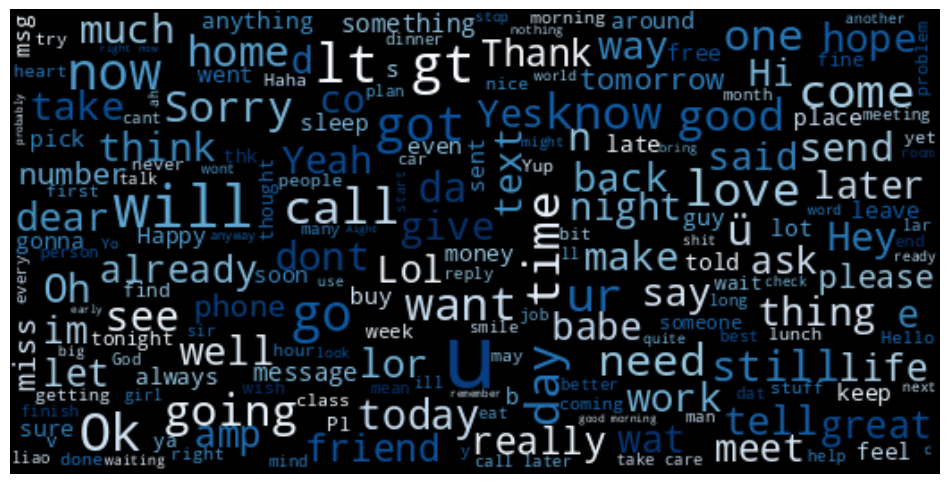

In [10]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50,
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(12,8))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

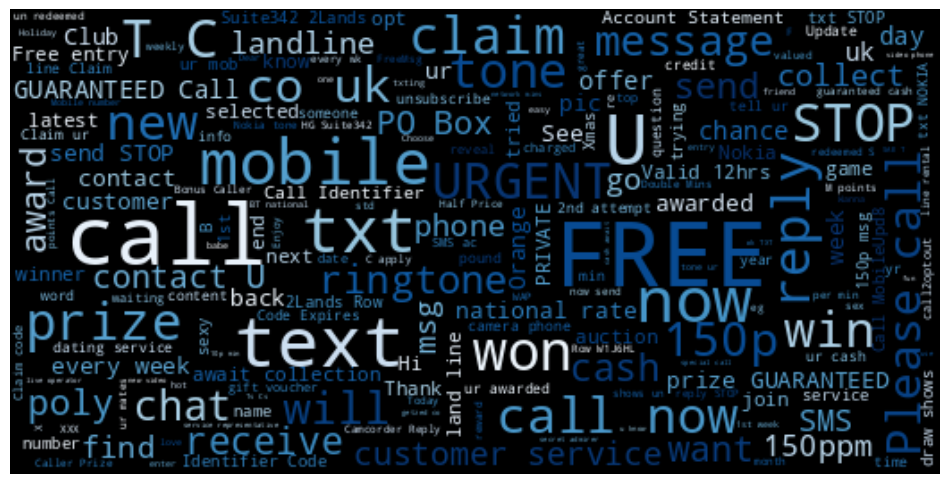

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50,
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(12,8))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [14]:
# # we can observe imbalance data here.
# plt.figure(figsize=(8,6))
# sns.countplot(messages.label)
# plt.title('Distribution of ham and spam email messages')

In [15]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

In [16]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [17]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [18]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

<ipython-input-18-742b017fc9d7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


In [20]:
# plt.figure(figsize=(8,6))
# sns.countplot(msg_df.label)
# plt.title('Distribution of ham and spam email messages (after downsampling)')
# plt.xlabel('Message types')

In [22]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

<ipython-input-22-88d1e5e59715>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
ham,73.238286
spam,138.670683


#Prepare train test data and pre-processing text

In [23]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [25]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=4)

In [26]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [27]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [63]:
# Get the word_index
word_index = tokenizer.word_index
word_index

In [29]:
# check how many words
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4204 unique tokens in training data. 


# Sequencing and padding

In [30]:
# Sequencing and padding on training and testing
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [31]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [32]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [33]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [34]:
# As can be seen from below, the padded sequence is 50 words long.
print(training_padded[0])

[240   1 420 457   1  24 178   2 125   4   1 163  43   3   1   4   1  56
   6   1   1  37 135   1   1 421   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#Train the Model

In [35]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [36]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [38]:
# Compile model
#from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
#optim = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [39]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6866 - accuracy: 0.6343 - val_loss: 0.6781 - val_accuracy: 0.8595 - 2s/epoch - 61ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6635 - accuracy: 0.8552 - val_loss: 0.6427 - val_accuracy: 0.8495 - 119ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6132 - accuracy: 0.8695 - val_loss: 0.5764 - val_accuracy: 0.8662 - 111ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5288 - accuracy: 0.8937 - val_loss: 0.4859 - val_accuracy: 0.8729 - 119ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4394 - accuracy: 0.8929 - val_loss: 0.3982 - val_accuracy: 0.8796 - 106ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3561 - accuracy: 0.8979 - val_loss: 0.3277 - val_accuracy: 0.9030 - 132ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2949 - accuracy: 0.9071 - val_loss: 0.2756 - val_accuracy: 0.9130 - 114ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2531 - accuracy: 0.9280 - val_loss: 0.2367 - val_accuracy: 0.9197 - 119ms/epoch - 3ms/step
Epoch 9/30
38/38 -

In [40]:
# Model performermance on test data is about 95.65% accuracy with validation loss of 0.11.
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.9565


[0.10941045731306076, 0.95652174949646]

In [41]:

metrics = pd.DataFrame(history.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.686597,0.63431,0.678096,0.859532
1,0.663525,0.85523,0.642735,0.849498


In [42]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.686597,0.63431,0.678096,0.859532
1,0.663525,0.85523,0.642735,0.849498


In [43]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

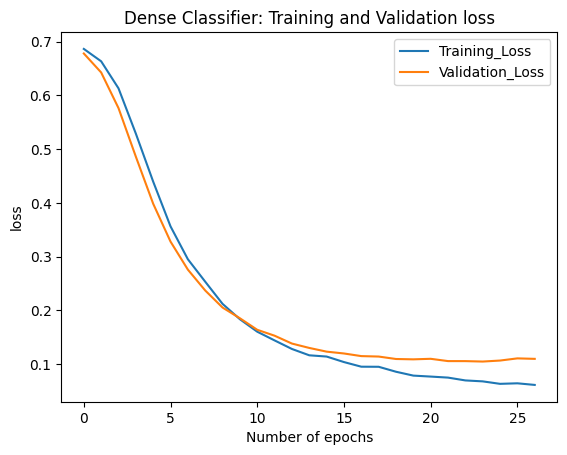

In [44]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

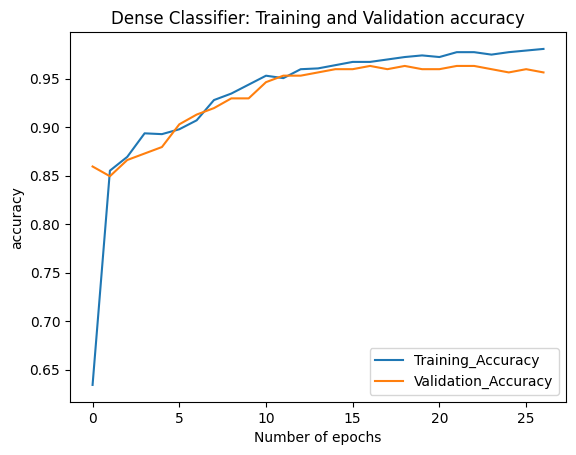

In [45]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#Long Short Term Memory (LSTM) layer architecture

In [46]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [47]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [48]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [64]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
#history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
history1 =model.fit(training_padded,train_labels,epochs=30,validation_data=(testing_padded, test_labels))


Epoch 1/30
38/38 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.9816 - val_loss: 0.1056 - val_accuracy: 0.9599
Epoch 2/30
38/38 [==============================] - 0s 8ms/step - loss: 0.0488 - accuracy: 0.9858 - val_loss: 0.1059 - val_accuracy: 0.9599
Epoch 3/30
38/38 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9849 - val_loss: 0.1064 - val_accuracy: 0.9599
Epoch 4/30
38/38 [==============================] - 0s 7ms/step - loss: 0.0457 - accuracy: 0.9883 - val_loss: 0.1063 - val_accuracy: 0.9599
Epoch 5/30
38/38 [==============================] - 0s 6ms/step - loss: 0.0426 - accuracy: 0.9891 - val_loss: 0.1079 - val_accuracy: 0.9565
Epoch 6/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9874 - val_loss: 0.1082 - val_accuracy: 0.9599
Epoch 7/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0425 - accuracy: 0.9900 - val_loss: 0.1070 - val_accuracy: 0.9565
Epoch 8/30
38/38 [==

In [65]:
# Create a dataframe
metrics = pd.DataFrame(history1.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

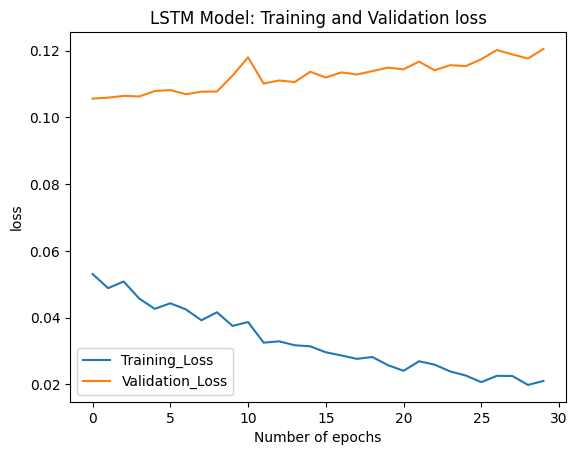

In [66]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

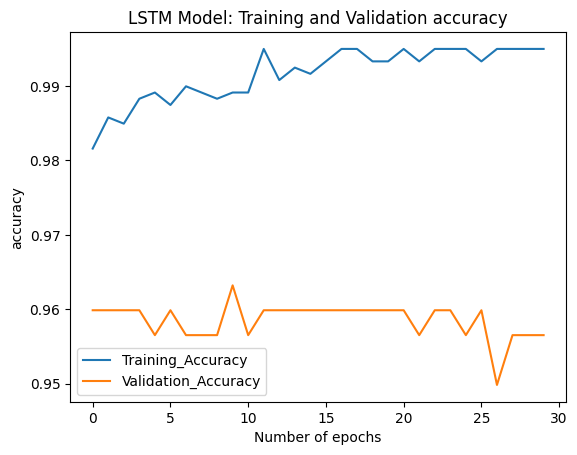

In [67]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#Biderectional LSTM (Bi-LSTM)

In [68]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [69]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


In [72]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
#history2 = model2.fit(training_padded, train_labels, epochs=num_epochs,validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
history2 =model.fit(training_padded,train_labels,epochs=num_epochs,validation_data=(testing_padded, test_labels))

Epoch 1/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.1217 - val_accuracy: 0.9498
Epoch 2/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9958 - val_loss: 0.1213 - val_accuracy: 0.9599
Epoch 3/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.1234 - val_accuracy: 0.9465
Epoch 4/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9967 - val_loss: 0.1241 - val_accuracy: 0.9498
Epoch 5/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9975 - val_loss: 0.1227 - val_accuracy: 0.9532
Epoch 6/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.9975 - val_loss: 0.1257 - val_accuracy: 0.9498
Epoch 7/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9975 - val_loss: 0.1251 - val_accuracy: 0.9498
Epoch 8/30
38/38 [==

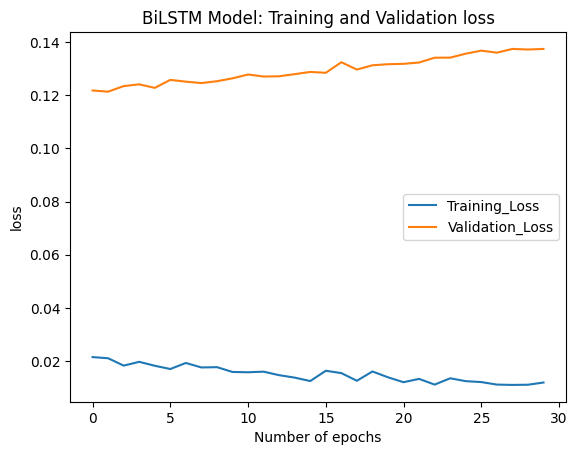

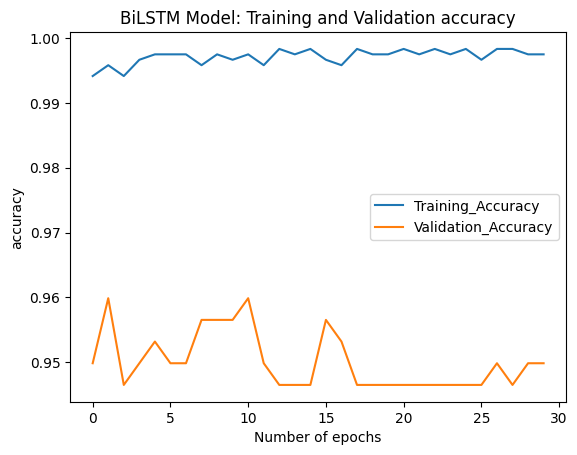

In [73]:
# Create a dataframe
metrics = pd.DataFrame(history2.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [75]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )


10/10 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9498
Dense architecture loss and accuracy: [0.13737623393535614, 0.9498327970504761] 


#Predict sentiment for new messages

In [77]:
# display long string
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [78]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [79]:
predict_spam(predict_msg)

1/1 [==============================] - 0s 111ms/step


array([[1.3324621e-04],
       [7.7158614e-04],
       [1.0000000e+00]], dtype=float32)

In [80]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 27ms/step


array([[0.9949876 ],
       [0.01500453],
       [0.00106434]], dtype=float32)